In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("course_lead_scoring.csv")
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [3]:
df.isnull().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [4]:
categorical = ['lead_source', 'industry', 'employment_status', 'location']
numerical = ['number_of_courses_viewed', 'annual_income', 'interaction_count', 'lead_score']

df[numerical] = df[numerical].fillna(0)
df[categorical] = df[categorical].fillna('NA')

In [5]:
df.isnull().sum()

lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64

In [6]:
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

len(df_train), len(df_val), len(df_test)

(876, 293, 293)

In [7]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.converted.values
y_val = df_val.converted.values
y_test = df_test.converted.values

del df_train['converted']
del df_val['converted']
del df_test['converted']

# Q1: ROC values

In [9]:
from sklearn.metrics import roc_auc_score

numerical_variables = ['lead_score', 'number_of_courses_viewed', 'interaction_count', 'annual_income']

auc_scores = {}

for var in numerical_variables:
    # Use the variable as the prediction score
    score = df_train[var].values
    
    # Calculate AUC
    auc = roc_auc_score(y_train, score)
    
    # If AUC < 0.5, invert the variable
    if auc < 0.5:
        auc = roc_auc_score(y_train, -score)
        print(f'{var}: AUC = {auc:.4f} (inverted)')
    else:
        print(f'{var}: AUC = {auc:.4f}')
    
    auc_scores[var] = auc

# Find the variable with the highest AUC
best_variable = max(auc_scores, key=auc_scores.get)
print(f'\nBest variable: {best_variable} with AUC = {auc_scores[best_variable]:.4f}')

lead_score: AUC = 0.6145
number_of_courses_viewed: AUC = 0.7636
interaction_count: AUC = 0.7383
annual_income: AUC = 0.5520

Best variable: number_of_courses_viewed with AUC = 0.7636


# Q2: Training the model

In [10]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

train_dicts = df_train[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
test_dicts = df_test[categorical + numerical].to_dict(orient='records')

X_val = dv.transform(val_dicts)
X_test = dv.transform(test_dicts)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'liblinear'
,max_iter,1000
,multi_class,'deprecated'


In [ ]:
model.predict_proba(X_val)

In [23]:
# Get probability predictions for the positive class (converted = 1)
y_pred_val = model.predict_proba(X_val)[:, 1]

# Calculate ROC AUC score
auc_val = roc_auc_score(y_val, y_pred_val)
print(f"ROC AUC score of the model on the validation set: {auc_val:.3f}")

ROC AUC score of the model on the validation set: 0.817


# Q3: Precision and Recall

In [32]:
thresholds = np.arange(0.0, 1.01, 0.01)
thresholds

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99, 1.  ])

c:\Python_Projects_new\ML Zoomcamp\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Python_Projects_new\ML Zoomcamp\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Python_Projects_new\ML Zoomcamp\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


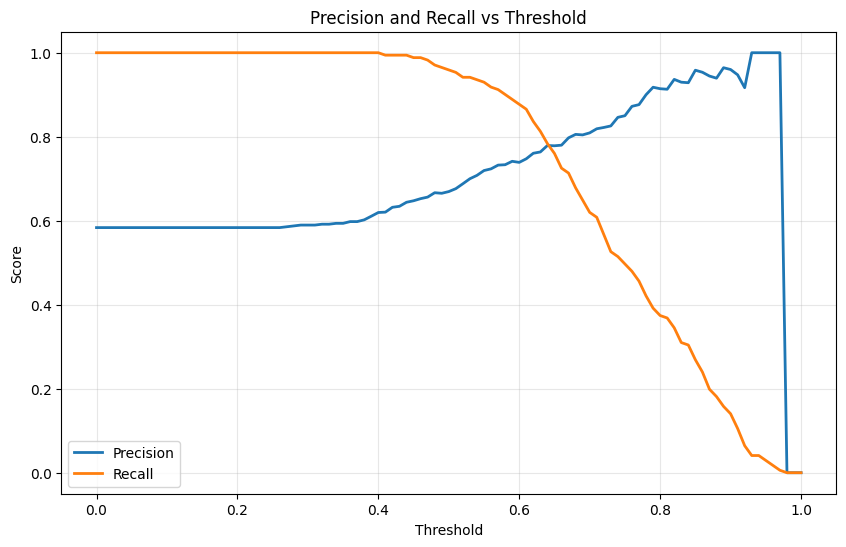

In [34]:
from sklearn.metrics import recall_score, precision_score

precision_scores = []
recall_scores = []

for t in thresholds:
    y_pred_threshold = model.predict_proba(X_val)[:, 1] >= t
    precision = precision_score(y_val, y_pred_threshold)
    recall = recall_score(y_val, y_pred_threshold)
    precision_scores.append(precision)
    recall_scores.append(recall)

# Plot precision and recall curves
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision_scores, label='Precision', linewidth=2)
plt.plot(thresholds, recall_scores, label='Recall', linewidth=2)
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs Threshold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

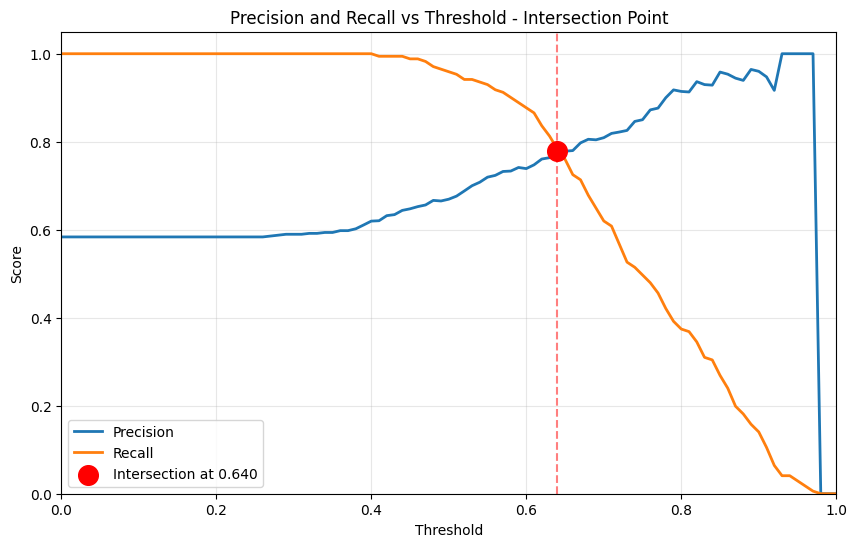

In [37]:
# Visualize the intersection point
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision_scores, label='Precision', linewidth=2)
plt.plot(thresholds, recall_scores, label='Recall', linewidth=2)
plt.scatter([intersection_threshold], [intersection_precision], 
            color='red', s=200, zorder=5, label=f'Intersection at {intersection_threshold:.3f}')
plt.axvline(x=intersection_threshold, color='red', linestyle='--', alpha=0.5)
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs Threshold - Intersection Point')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(0, 1)
plt.ylim(0, 1.05)
plt.show()

In [38]:
# Check precision and recall at the given threshold options
threshold_options = [0.145, 0.345, 0.545, 0.745]

print("Checking threshold options:")
for t_opt in threshold_options:
    idx = np.argmin(np.abs(thresholds - t_opt))
    actual_t = thresholds[idx]
    prec = precision_scores[idx]
    rec = recall_scores[idx]
    diff = abs(prec - rec)
    print(f"Threshold {t_opt:.3f} (actual: {actual_t:.3f}): Precision={prec:.3f}, Recall={rec:.3f}, Diff={diff:.3f}")

print(f"\nClosest match to calculated intersection ({intersection_threshold:.3f}): {min(threshold_options, key=lambda x: abs(x - intersection_threshold))}")

Checking threshold options:
Threshold 0.145 (actual: 0.140): Precision=0.584, Recall=1.000, Diff=0.416
Threshold 0.345 (actual: 0.340): Precision=0.594, Recall=1.000, Diff=0.406
Threshold 0.545 (actual: 0.540): Precision=0.708, Recall=0.936, Diff=0.228
Threshold 0.745 (actual: 0.740): Precision=0.846, Recall=0.515, Diff=0.332

Closest match to calculated intersection (0.640): 0.545


In [43]:
# Display the intersection threshold
print(f"Precision-Recall intersection threshold: {intersection_threshold:.3f}")

Precision-Recall intersection threshold: 0.640


# Q4: F1 Score

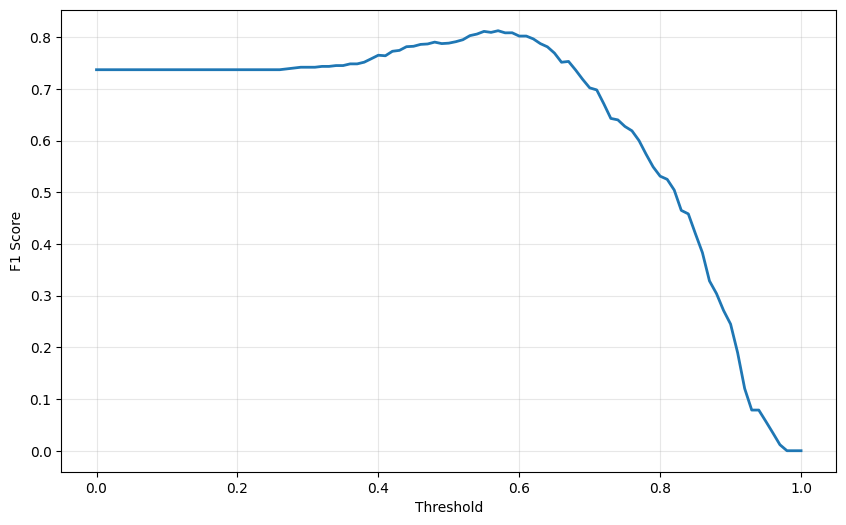

In [40]:
f1_scores = []

for i in range(len(thresholds)):

    f1_score_ = 2 * (precision_scores[i] * recall_scores[i]) / (precision_scores[i] + recall_scores[i] + 1e-6)
    f1_scores.append(f1_score_)

# Plot precision and recall curves
plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores, label='F1 Score', linewidth=2)
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.grid(True, alpha=0.3)
plt.show()


In [44]:
# Find the threshold with maximum F1 score
max_f1_idx = np.argmax(f1_scores)
max_f1_threshold = thresholds[max_f1_idx]
max_f1_value = f1_scores[max_f1_idx]

print(f"Maximum F1 score: {max_f1_value:.4f}")
print(f"At threshold: {max_f1_threshold:.3f}")

# Check the given options
f1_threshold_options = [0.14, 0.34, 0.54, 0.74]
print("\nChecking F1 at threshold options:")
for t_opt in f1_threshold_options:
    idx = np.argmin(np.abs(thresholds - t_opt))
    print(f"Threshold {t_opt:.2f}: F1 = {f1_scores[idx]:.4f}")

print(f"\nClosest option to max F1 threshold ({max_f1_threshold:.3f}): {min(f1_threshold_options, key=lambda x: abs(x - max_f1_threshold))}")

Maximum F1 score: 0.8125
At threshold: 0.570

Checking F1 at threshold options:
Threshold 0.14: F1 = 0.7371
Threshold 0.34: F1 = 0.7451
Threshold 0.54: F1 = 0.8060
Threshold 0.74: F1 = 0.6400

Closest option to max F1 threshold (0.570): 0.54


# Q5: 5-Fold CV

In [41]:
from sklearn.model_selection import KFold

# Initialize KFold
kf = KFold(n_splits=5, shuffle=True, random_state=1)

# Store AUC scores for each fold
auc_scores_folds = []

# Iterate over folds
for fold, (train_idx, val_idx) in enumerate(kf.split(df_full_train), 1):
    # Split data
    df_fold_train = df_full_train.iloc[train_idx]
    df_fold_val = df_full_train.iloc[val_idx]
    
    # Separate target variable
    y_fold_train = df_fold_train.converted.values
    y_fold_val = df_fold_val.converted.values
    
    # Remove target from features
    df_fold_train = df_fold_train.drop('converted', axis=1)
    df_fold_val = df_fold_val.drop('converted', axis=1)
    
    # Prepare data for DictVectorizer
    train_dicts_fold = df_fold_train[categorical + numerical].to_dict(orient='records')
    val_dicts_fold = df_fold_val[categorical + numerical].to_dict(orient='records')
    
    # Transform data
    dv_fold = DictVectorizer(sparse=False)
    X_fold_train = dv_fold.fit_transform(train_dicts_fold)
    X_fold_val = dv_fold.transform(val_dicts_fold)
    
    # Train model
    model_fold = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model_fold.fit(X_fold_train, y_fold_train)
    
    # Predict and evaluate
    y_pred_fold = model_fold.predict_proba(X_fold_val)[:, 1]
    auc_fold = roc_auc_score(y_fold_val, y_pred_fold)
    auc_scores_folds.append(auc_fold)
    
    print(f'Fold {fold}: AUC = {auc_fold:.4f}')

# Calculate mean and standard deviation
mean_auc = np.mean(auc_scores_folds)
std_auc = np.std(auc_scores_folds)

print(f'\nMean AUC: {mean_auc:.4f}')
print(f'Standard Deviation: {std_auc:.4f}')

Fold 1: AUC = 0.8061
Fold 2: AUC = 0.8714
Fold 3: AUC = 0.7754
Fold 4: AUC = 0.8018
Fold 5: AUC = 0.8558

Mean AUC: 0.8221
Standard Deviation: 0.0358
Fold 4: AUC = 0.8018
Fold 5: AUC = 0.8558

Mean AUC: 0.8221
Standard Deviation: 0.0358


# Q6: Hyperparameter Tuning

In [42]:
# C values to test
C_values = [0.000001, 0.001, 1]

# Store results
results = []

# Test each C value
for C in C_values:
    print(f'\nTesting C = {C}')
    print('-' * 40)
    
    # Initialize KFold
    kf = KFold(n_splits=5, shuffle=True, random_state=1)
    
    # Store AUC scores for each fold
    auc_scores = []
    
    # Iterate over folds
    for fold, (train_idx, val_idx) in enumerate(kf.split(df_full_train), 1):
        # Split data
        df_fold_train = df_full_train.iloc[train_idx]
        df_fold_val = df_full_train.iloc[val_idx]
        
        # Separate target variable
        y_fold_train = df_fold_train.converted.values
        y_fold_val = df_fold_val.converted.values
        
        # Remove target from features
        df_fold_train = df_fold_train.drop('converted', axis=1)
        df_fold_val = df_fold_val.drop('converted', axis=1)
        
        # Prepare data for DictVectorizer
        train_dicts = df_fold_train[categorical + numerical].to_dict(orient='records')
        val_dicts = df_fold_val[categorical + numerical].to_dict(orient='records')
        
        # Transform data
        dv_cv = DictVectorizer(sparse=False)
        X_fold_train = dv_cv.fit_transform(train_dicts)
        X_fold_val = dv_cv.transform(val_dicts)
        
        # Train model with specific C
        model_cv = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model_cv.fit(X_fold_train, y_fold_train)
        
        # Predict and evaluate
        y_pred = model_cv.predict_proba(X_fold_val)[:, 1]
        auc = roc_auc_score(y_fold_val, y_pred)
        auc_scores.append(auc)
        
        print(f'  Fold {fold}: AUC = {auc:.4f}')
    
    # Calculate statistics
    mean_auc = np.mean(auc_scores)
    std_auc = np.std(auc_scores)
    
    results.append({
        'C': C,
        'mean': round(mean_auc, 3),
        'std': round(std_auc, 3),
        'scores': auc_scores
    })
    
    print(f'  Mean AUC: {mean_auc:.3f}')
    print(f'  Std AUC: {std_auc:.3f}')

# Summary
print('\n' + '='*50)
print('SUMMARY')
print('='*50)
for r in results:
    print(f"C = {r['C']:>10} | Mean = {r['mean']:.3f} | Std = {r['std']:.3f}")

# Find best C (highest mean, then lowest std, then smallest C)
best = sorted(results, key=lambda x: (-x['mean'], x['std'], x['C']))[0]
print(f"\nBest C: {best['C']} (Mean = {best['mean']:.3f}, Std = {best['std']:.3f})")


Testing C = 1e-06
----------------------------------------
  Fold 1: AUC = 0.5572
  Fold 2: AUC = 0.5192
  Fold 3: AUC = 0.5895
  Fold 4: AUC = 0.5582
  Fold 5: AUC = 0.5769
  Mean AUC: 0.560
  Std AUC: 0.024

Testing C = 0.001
----------------------------------------
  Fold 1: AUC = 0.8609
  Fold 2: AUC = 0.8967
  Fold 3: AUC = 0.8228
  Fold 4: AUC = 0.8540
  Fold 5: AUC = 0.9000
  Mean AUC: 0.867
  Std AUC: 0.029

Testing C = 1
----------------------------------------
  Fold 1: AUC = 0.8061
  Fold 2: AUC = 0.8714
  Fold 3: AUC = 0.7754
  Fold 4: AUC = 0.8018
  Fold 5: AUC = 0.8558
  Mean AUC: 0.822
  Std AUC: 0.036

SUMMARY
C =      1e-06 | Mean = 0.560 | Std = 0.024
C =      0.001 | Mean = 0.867 | Std = 0.029
C =          1 | Mean = 0.822 | Std = 0.036

Best C: 0.001 (Mean = 0.867, Std = 0.029)
